## Analysis
Do the following analyses:
1. Plot mean rewards together for all runs by task
2. Plot success rate together for all runs by task
3. Plot Quantile of rewards together for all runs by task
4. Evaluate gating values and performance

Need a way of splitting out algorithm, task, run

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from plotting_utils import *

In [2]:
EXPERIMENT_LOG = '../../experiment_log.csv'
experiment_log = pd.read_csv(EXPERIMENT_LOG)


In [3]:
push_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='push-v2', setting='random')

In [4]:
## create baseline plot for right

In [4]:
test_data = push_experiments.get_result_group_data('test_results')
train_data = push_experiments.get_result_group_data('train_results')


In [6]:
## get data
## make plots
## rewards, successes, gating values

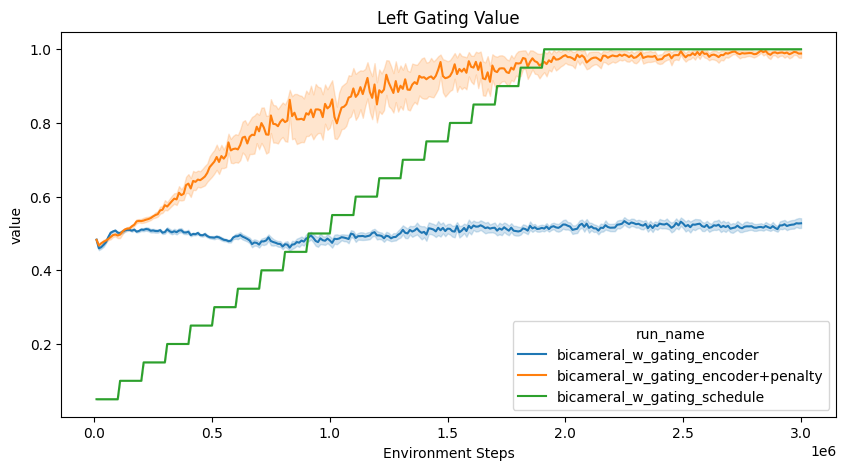

In [5]:
plot_gating_values(train_data.query("run_name.str.contains('bicameral')"), title = "Left Gating Value", figsize = (10, 5))

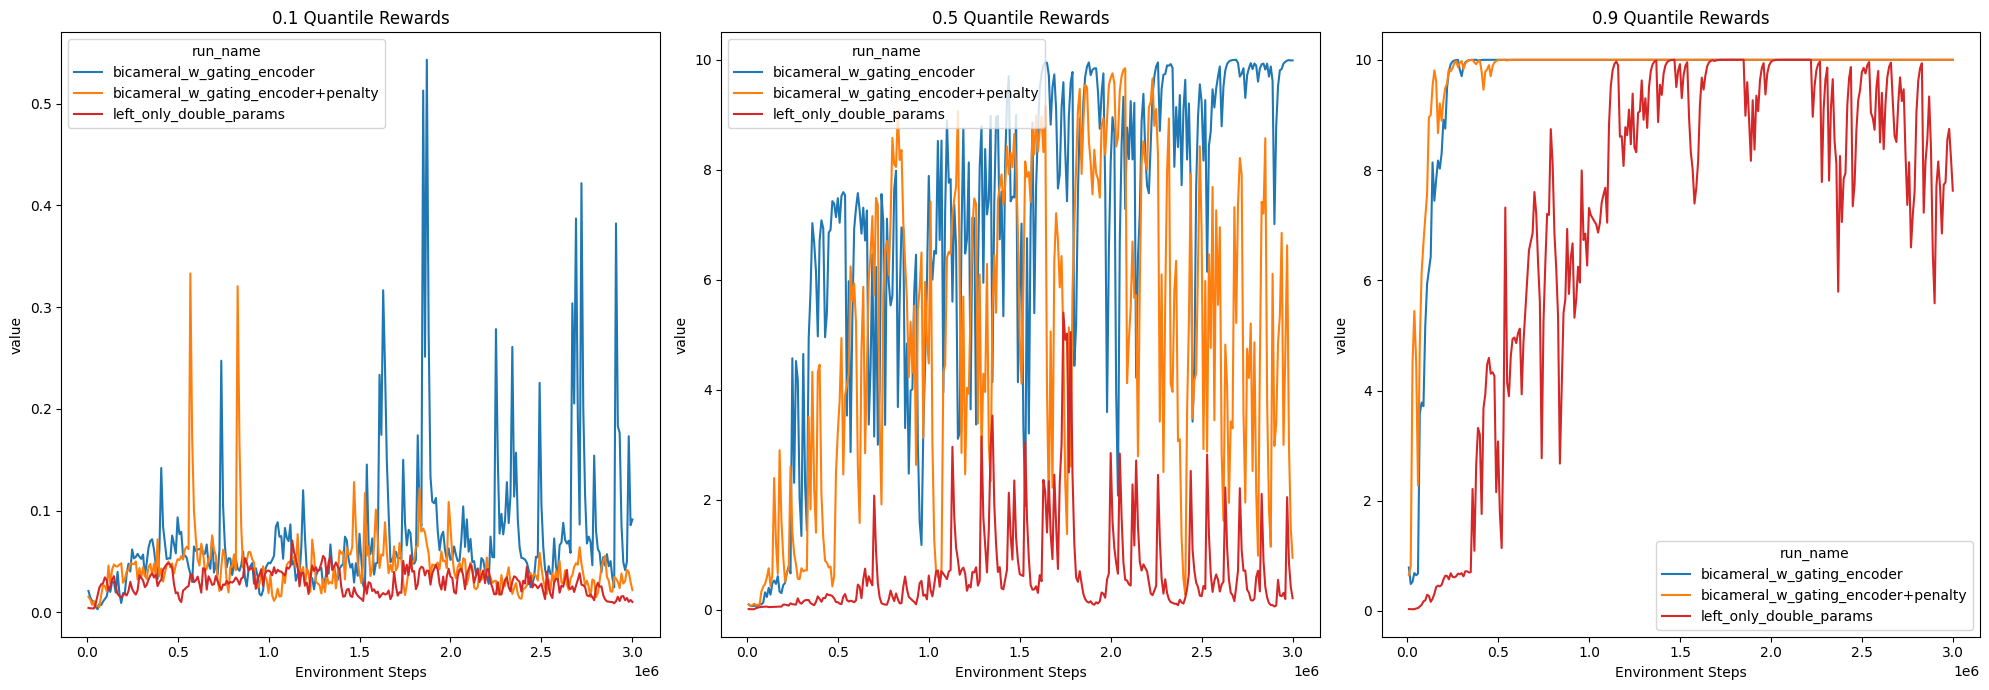

In [6]:
plot_rew_quantiles(
    (
        train_data
        .query(
            'run_name.isin(["bicameral_w_gating_encoder","bicameral_w_gating_encoder+penalty", "left_only_double_params"])'
            )
    ), 
    alpha = .6)

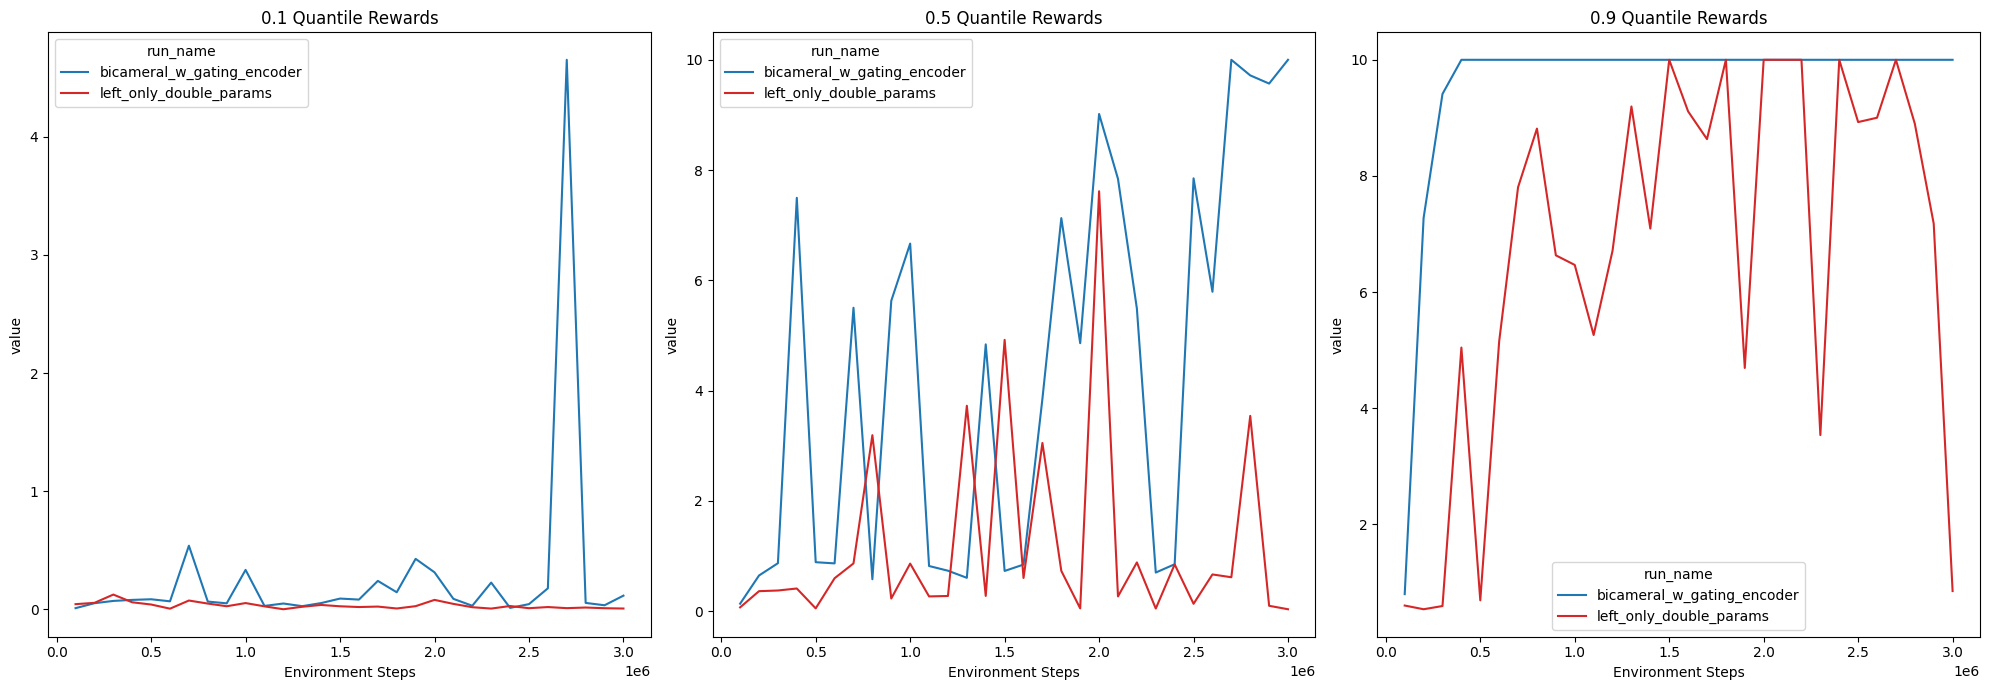

In [7]:
plot_rew_quantiles(test_data.query('run_name.isin(["bicameral_w_gating_encoder", "left_only_double_params"])'), alpha = 1)

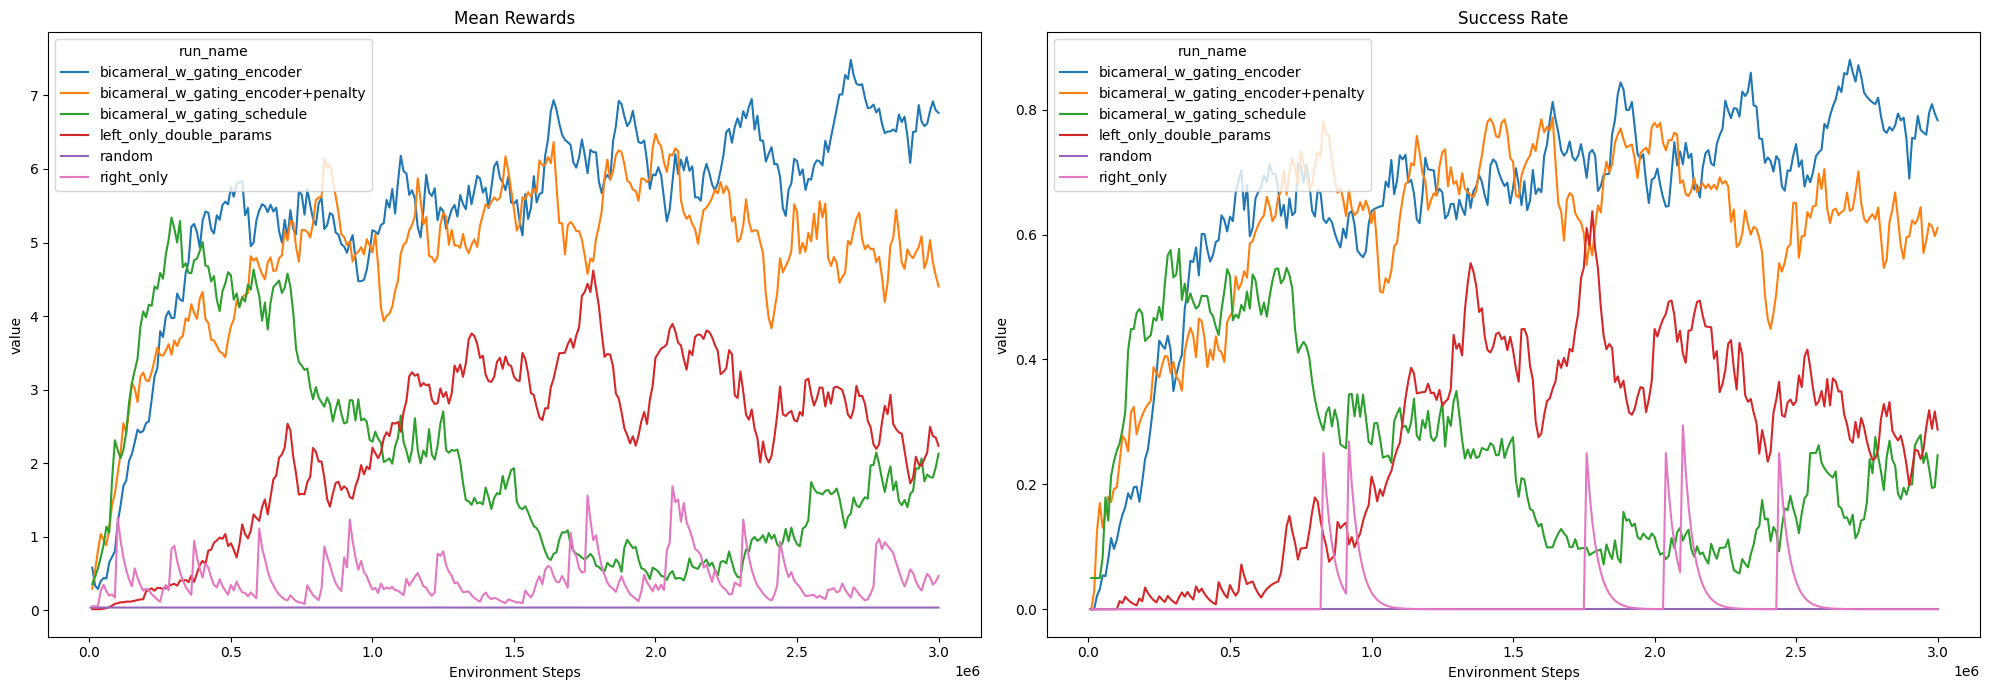

In [14]:
plot_rew_and_succ(train_data, alpha = .25)

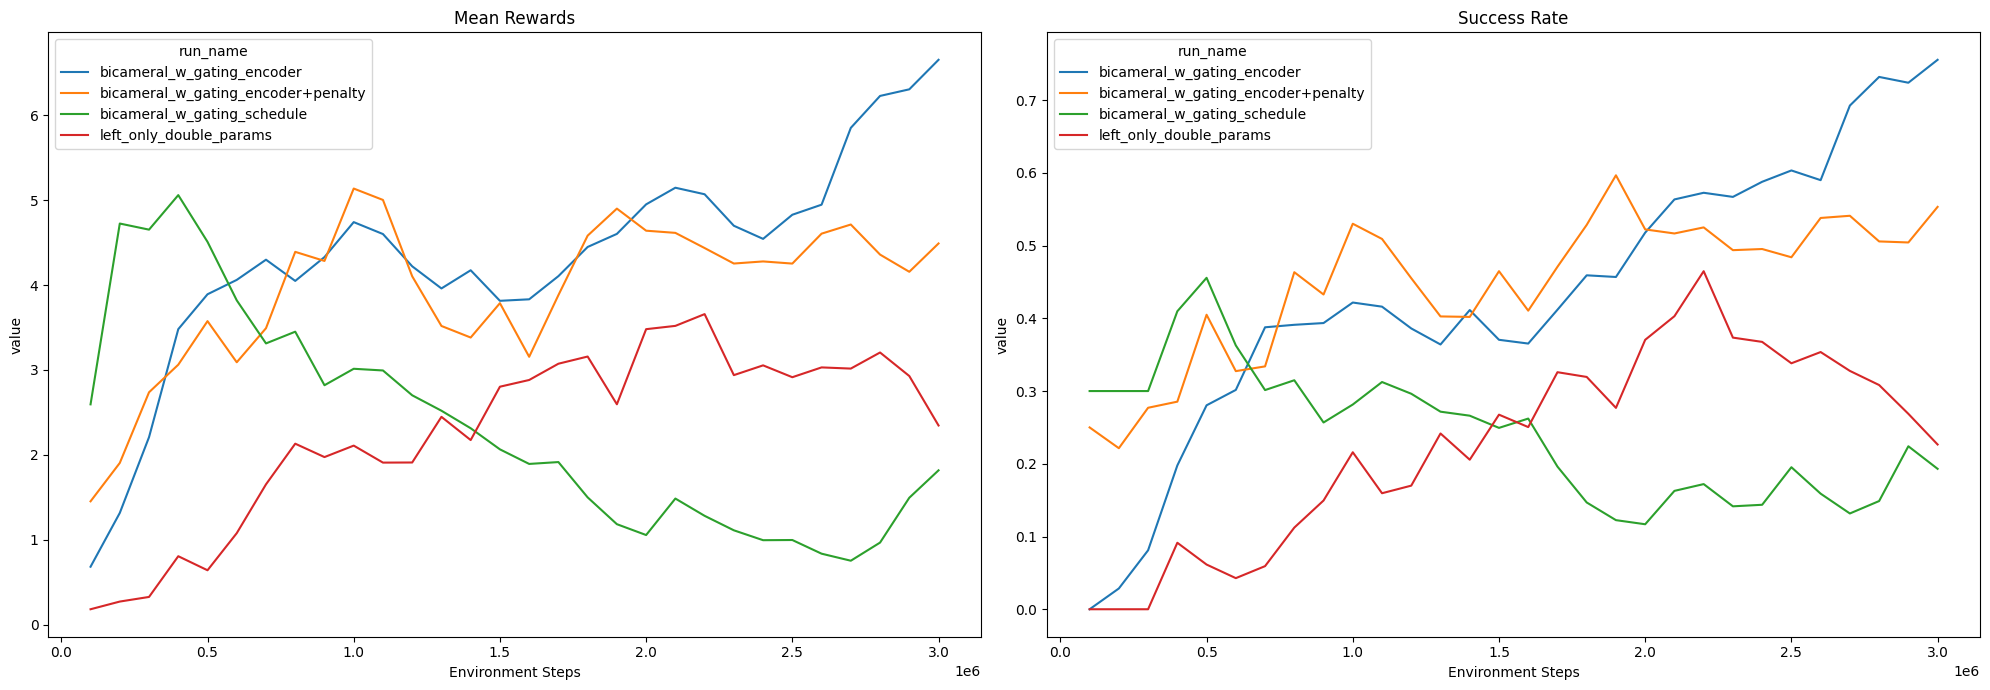

In [9]:
plot_rew_and_succ(test_data, alpha = .25)

In [18]:
def plot_baseline_barchart(data, title, figsize= (20, 7)):

    plot_df = (
        data
        .melt(id_vars=['frame', 'result_group', 'run_name', 'training_task'])
        .set_index('frame')
        .query(f'variable.isin({REWARD_QUANTILES})')
        .groupby(['result_group', 'run_name', 'training_task', 'variable'])
        .mean()
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=figsize)

    sns.barplot(
        data = plot_df,
        x = 'run_name',
        y = 'value',
        ax = ax
    )
    ax.set_title(title)

    plt.show();

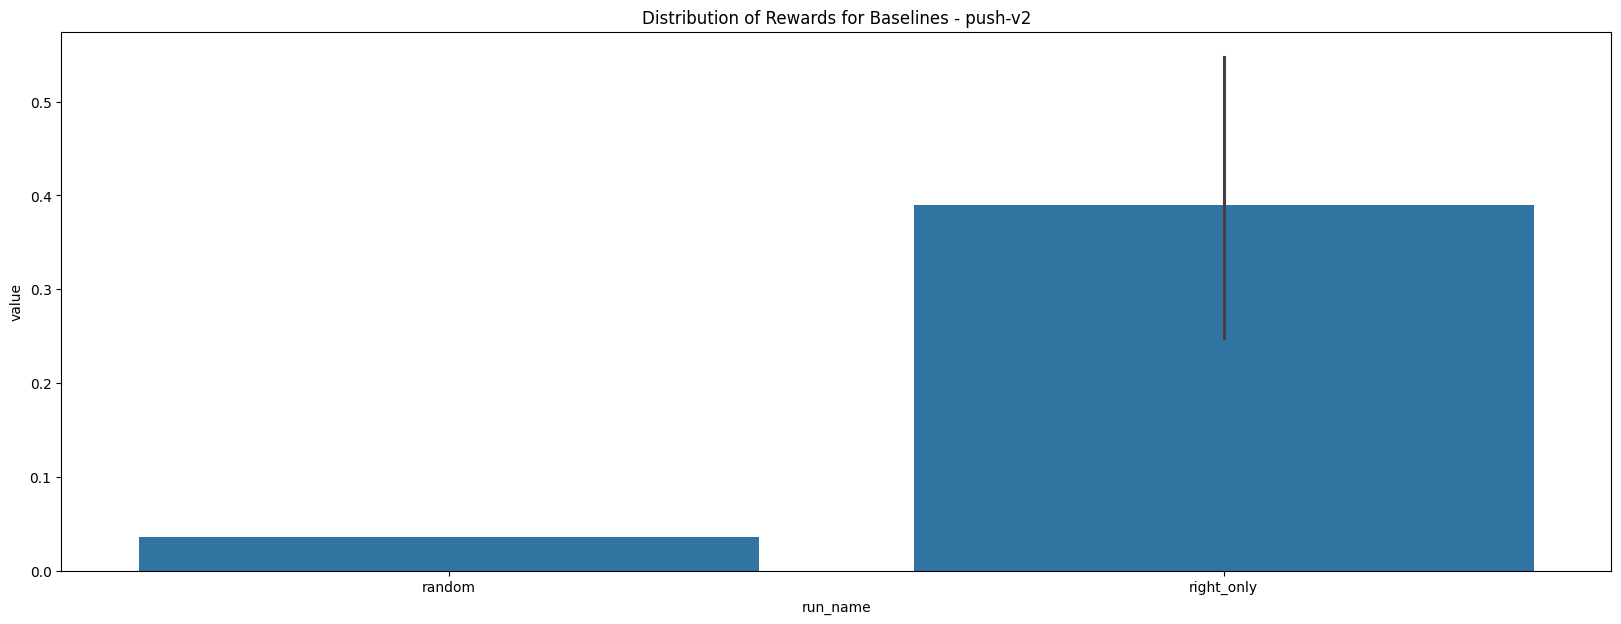

In [19]:
runs_to_do = ['right_only', 'random']
baseline_data = (
    train_data
    .query(f'run_name.isin({runs_to_do})')
)

plot_baseline_barchart(baseline_data, title="Distribution of Rewards for Baselines - push-v2")


In [29]:
np.unique(train_data.run_name)

array(['bicameral_w_gating_encoder', 'bicameral_w_gating_encoder+penalty',
       'bicameral_w_gating_schedule', 'left_only_double_params', 'random',
       'right_only'], dtype=object)

In [30]:


sns.lineplot(
    test_data,
    x
)

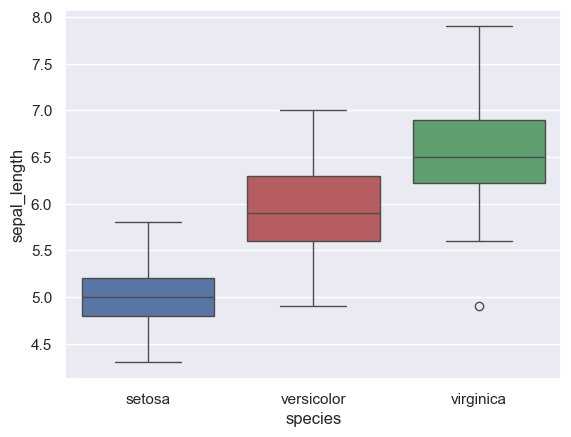

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
df = sns.load_dataset('iris')

my_pal = {"versicolor": "r", "setosa": "b", "virginica":"g"}
sns.boxplot(data = df, x="species", y="sepal_length", hue="species", palette=my_pal)
plt.show()

In [41]:
## plot training comparison - reward_mean, num_successes, reward_quantiles
## for train
train_results = (
    pd.concat(
        [all_results[k].data.query('result_group=="train_results"') for k in all_results.keys()]
    )
    .drop(['num_episodes', 'training_task', 'evaluation_task'], axis =1)
    .melt(id_vars = ['run_name', 'frame', 'result_group'])
)

## for test
## for test vs left
## note use right / random baselines for all

In [46]:
reward_quantiles = [f"rq_{i/10}" for i in range(1, 10)]

#### Compare whole bicameral to left_only network

In [117]:
avg_right_reward = right_only_results.data.reward_mean.mean()
avg_right_success = right_only_results.data.num_successes.mean()
combined_data = (
    pd.concat(
        [
            left_only_results.data, 
            (
                gate_lg_penalty_results
                .data
                .query('result_group.isin(["test_results", "train_results"])')
            )
        ]
    )
)


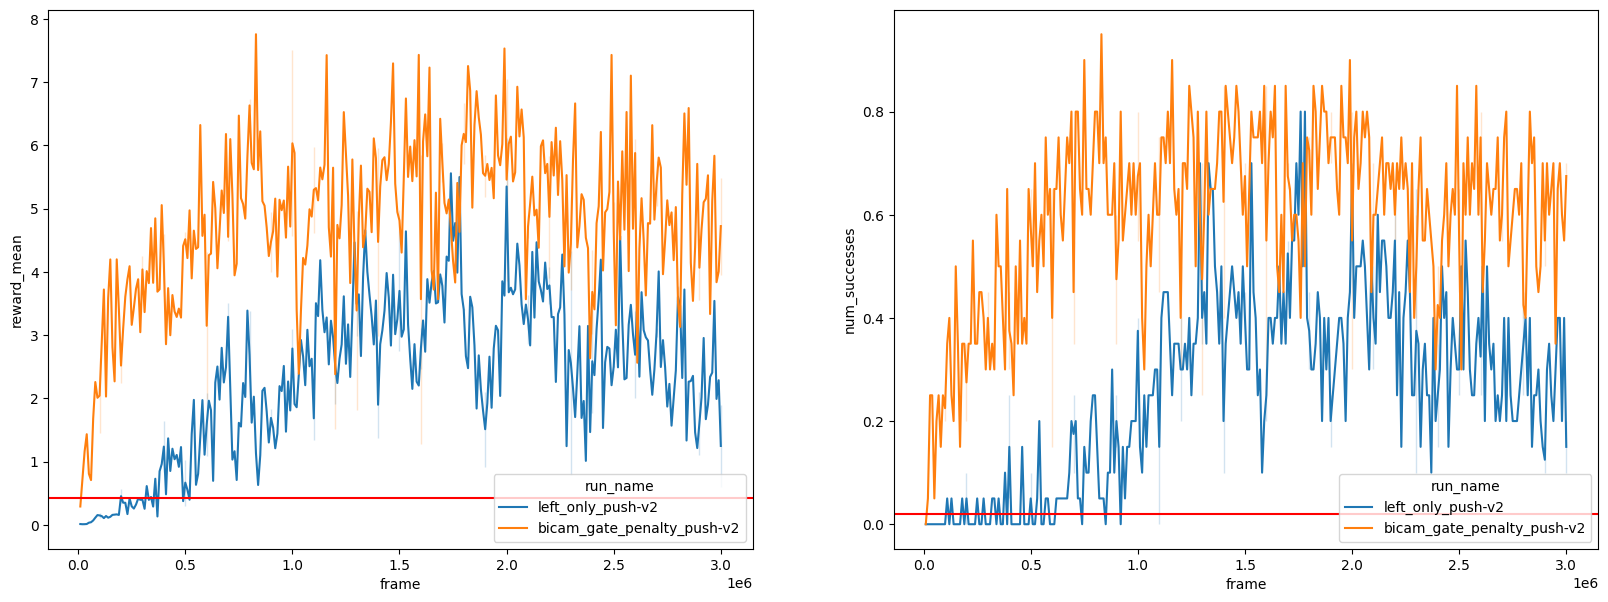

In [122]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

## mean reward
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'reward_mean',
    hue = 'run_name',
    ax = ax[0]
)

ax[0].axhline(avg_right_reward, c='r')

## successes
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'num_successes',
    hue = 'run_name',
    ax = ax[1]

)

ax[1].axhline(avg_right_success, c='r')

<Axes: xlabel='frame', ylabel='rq_0.9'>

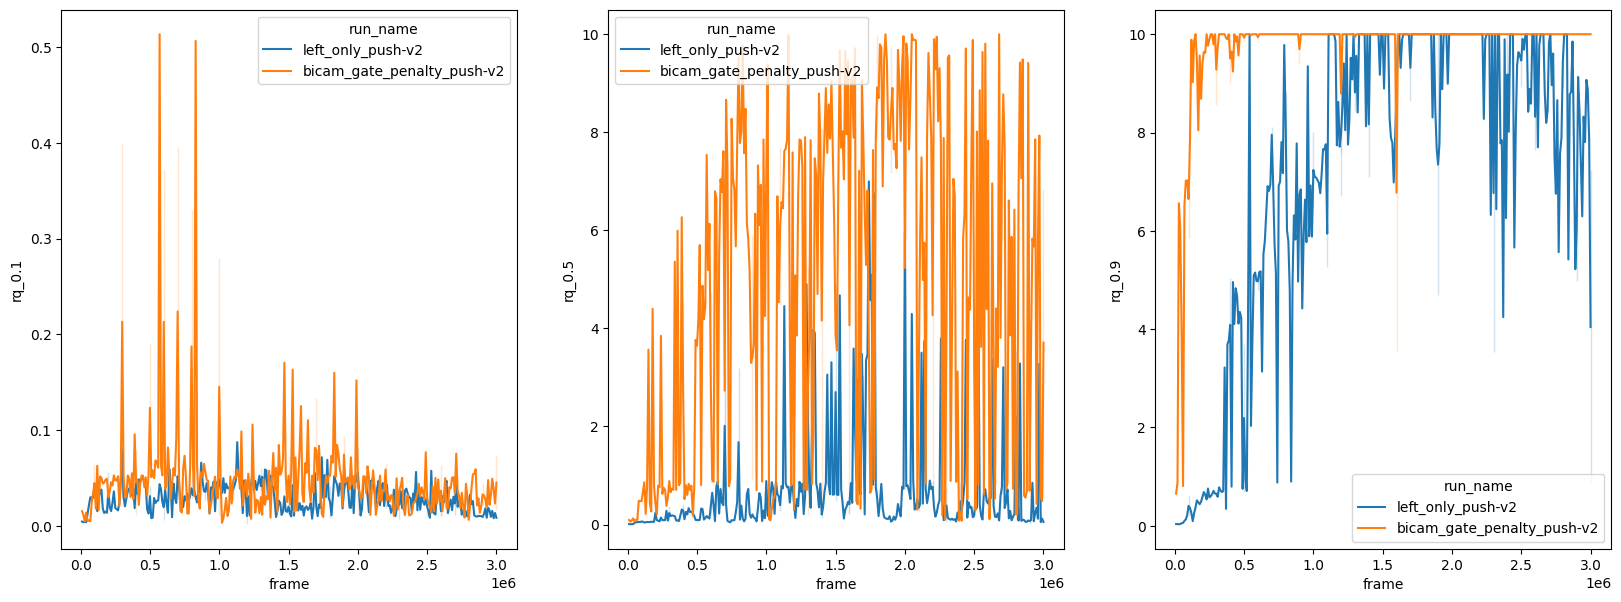

In [123]:
fig, ax = plt.subplots(1, 3, figsize = (20, 7))

## lowest decile
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'rq_0.1',
    hue = 'run_name',
    ax = ax[0]
)

## median
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'rq_0.5',
    hue = 'run_name',
    ax = ax[1]
)

# highest decile
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'rq_0.9',
    hue = 'run_name',
    ax = ax[2]
)

#### Compare left bicameral to left_only network

In [112]:
combined_plot_df = (
    pd.concat([
        (
            left_only_results
            .data
            .query('result_group=="test_results"')
        ), 
        (
            gate_lg_penalty_results
            .data
            .query('result_group=="left_eval_results"')
        )
    ])
    .loc[:, 
    ['result_group', 'frame', 'run_name', 'num_successes', 'reward_mean'] +\
    [f"rq_{i/10}" for i in range(1, 10)] + [f"gq_{i/10}" for i in range(1, 10)]
    ]
)

    

<Axes: xlabel='frame', ylabel='num_successes'>

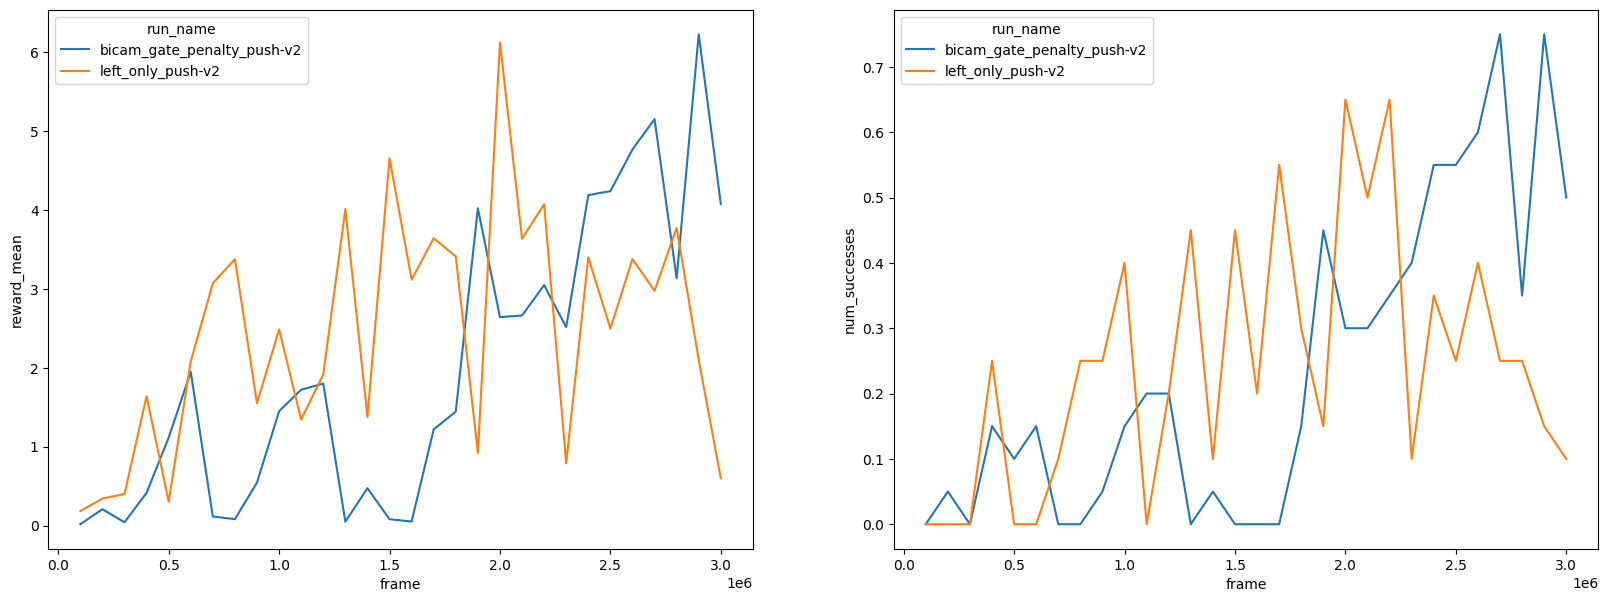

In [105]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

## mean reward
sns.lineplot(
    data = combined_plot_df,
    x = 'frame',
    y = 'reward_mean',
    hue = 'run_name',
    ax = ax[0]
)

## successes
sns.lineplot(
    data = combined_plot_df,
    x = 'frame',
    y = 'num_successes',
    hue = 'run_name',
    ax = ax[1]

)

<Axes: xlabel='frame', ylabel='value'>

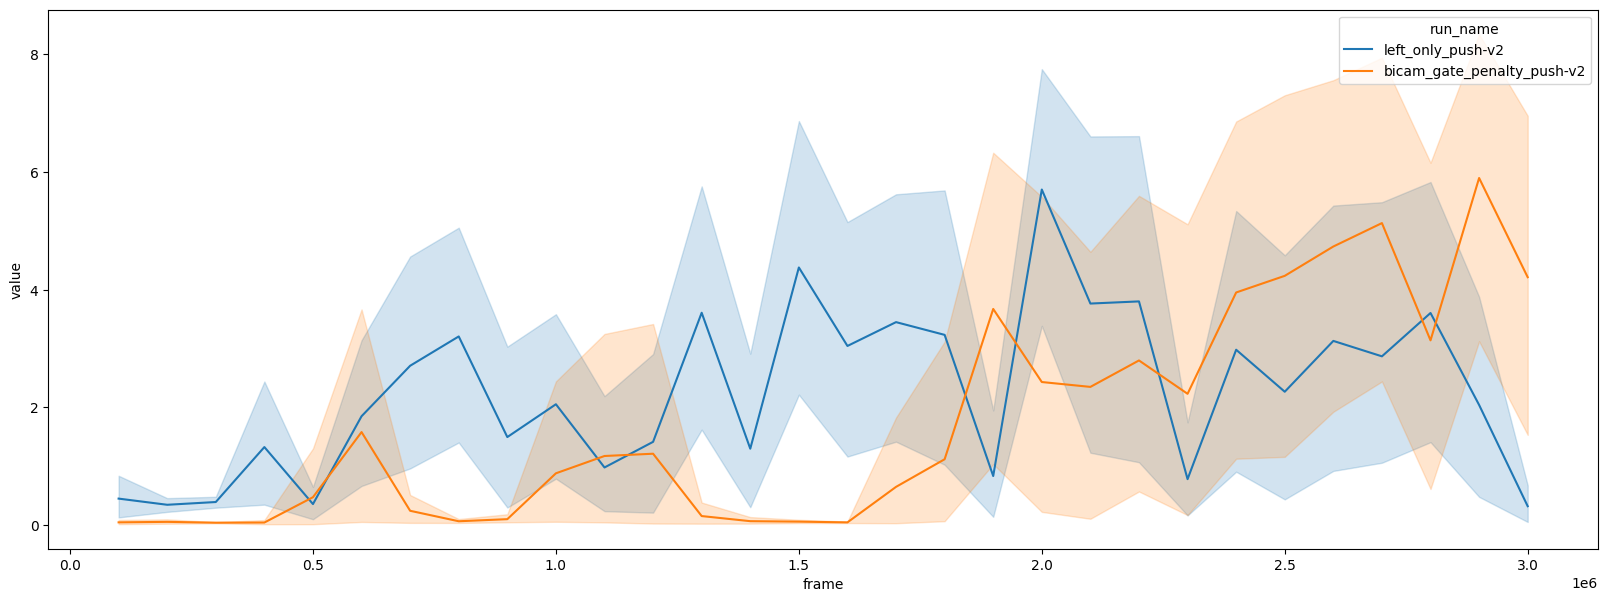

In [136]:
reward_qtiles = (
    combined_plot_df
    .melt(
        id_vars = ['result_group', 'run_name', 'frame'],
        value_vars = [f'rq_{i/10}' for i in range(1, 10)]
    )
    .set_index(['result_group', 'run_name', 'frame', 'variable'])
    .ewm(alpha = 0.9).mean()
)

fig, ax = plt.subplots(figsize = (20, 7))
sns.lineplot(
    data = reward_qtiles,
    x = 'frame',
    y = 'value',
    hue = 'run_name',
    ax = ax
)